### Import required libraries and functions

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from epik.src.utils import encode_seqs, split_training_test
from epik.src.model import EpiK
from epik.src.kernel import ConnectednessKernel, ExponentialKernel, JengaKernel

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In this tutorial, we will illustrate how to infer sequence-function relationships with our biologically interpretable Gaussian Process models, and guide the user in interpreting the results. 

With this aim, we will use a previously published dataset, in which the activity of nearly every possible GU/GC 5´splice site sequence was measured in parallel in a single experiment ([Wong et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30174293/)). The measured phenotype `y` is the percent spliced in, this is, the percentage of times a exon 7 is included in the mature mRNA. The assay was performed in different biological replicates, providing a measure of uncertainty of our estimates given by `y_var` as previously analyzed ([Zhou et al. 2022](https://pubmed.ncbi.nlm.nih.gov/36129941/))

### Load SMN1 data

We start by loading the data from the pre-processed csv file

In [2]:
data = pd.read_csv('../data/smn1.csv', index_col=0)
data

,y,y_var
seq,,
AAACAAAA,0.223881,0.001738
AAACAAAC,0.514961,0.009195
AAACAAAG,0.208009,0.001500
AAACAAAU,0.235378,0.002109
AAACAACA,0.357162,0.004423
...,...,...
UUUUUUGU,0.199017,0.001373
UUUUUUUA,0.074571,0.000536
UUUUUUUC,0.193181,0.001294


### Prepare data for model fitting

EpiK models assume that sequences are provided in a one-hot encoding `X` and provide the utility function `encode_seqs` to obtain them from the raw sequences

In [3]:
X = encode_seqs(data.index.values, alphabet='ACGU')
y = data['y'].values
y_var = data['y_var'].values

We next split the data into training and test subsets with `split_training_test`. To keep this tutorial as simple and fast to run as possible, we will use only a small subset of the dataset for both training and testing, but the code to run it with larger datasets will be exactly the same. 

In [4]:
splits = split_training_test(X, y, y_var, ptrain=0.05, dtype=torch.float32)
train_x, train_y, test_x, test_y, train_y_var = splits

# Subsample test data
idx = np.random.uniform(size=test_y.shape[0]) < 0.05
test_x, test_y = test_x[idx, :], test_y[idx]

### Fit Connectedness model regression

To define an `EpiK` model, we first need to specify the kernel function that we want to use for Gaussian process regression. In this case, we will use the `ConnectednessKernel`, in which the predictability of mutational effects decreases as we add mutations depending on site-specific decay factors. As the number of parameters is equal to sequence lenght, this kernel provides a good compromise in datasets with relatively few measurements as this one. For every kernel class, we need to specify the configuration of sequence space, consisting of the number of alleles and sequence length. 

In [5]:
kernel = ConnectednessKernel(n_alleles=4, seq_length=8)
model = EpiK(kernel, track_progress=True, learning_rate=0.05)
model.set_data(train_x, train_y, train_y_var)

After defining the `EpiK` model, we load the training data in the model and optimize the kernel hyperparameters by maximizing the marginal likelihood using the Adam optimizer for a number of predefined iterations. The argument `track_progress=True` allows us to follow the progress of the optimization and track how the loss function decreases

In [6]:
model.fit(n_iter=100)

Optimizing hyperparameters: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s, loss=3.947]


### Make predictions on test sequences

Once we have optimized the hyperparameters of the kernel function, we can make predictions by computing the posterior distribution over the sequence-function relationship evaluated at sequences of interest. This allows us to obtain point estimates `test_y_pred` that maximize this posterior probability, but we can additionally compute the posterior variance `test_y_var` quantifying the uncertainty of the predictions. 

Lets now make predictions in the test sequences that the model has not seen. 

In [7]:
test_y_pred, test_y_var = model.predict(test_x, calc_variance=True)

Once we have the predictions, we can compare them with the measurements for these held-out sequences, for instance, by computing the $R^2$ or the calibration of the uncertainty by calculating the percentage of times the measurement is within the 95% predictive interval

In [8]:
r2 = pearsonr(test_y_pred, test_y)[0] ** 2
sd = np.sqrt(test_y_var.numpy())
calibration = ((test_y > test_y_pred - 2 * sd) & (test_y < test_y_pred + 2 * sd)).numpy().mean()

[Text(0.5, 0, 'Predicted PSI (%)'),
 (-20.0, 200.0),
 Text(0, 0.5, 'Measured PSI (%)'),
 (-20.0, 200.0),
 None]

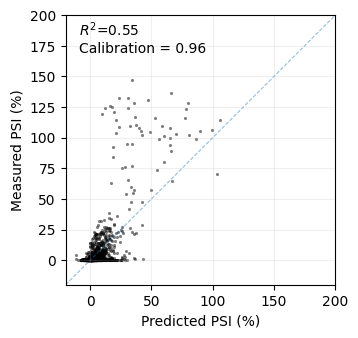

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3.5))
lims = (-20, 200)
axes.scatter(test_y_pred, test_y, s=5, c='black', lw=0, alpha=0.5)
axes.plot(lims, lims, lw=0.75, linestyle='--', alpha=0.5)
axes.grid(alpha=0.2)
axes.text(0.05, 0.98, '$R^2$=' + '{:.2f}\nCalibration = {:.2f}'.format(r2, calibration),
          transform=axes.transAxes, ha='left', va='top')
axes.set(xlabel='Predicted PSI (%)', xlim=lims, 
         ylabel='Measured PSI (%)', ylim=lims, aspect='equal')

This scatterplots shows the relatively good performance of this model in predicting the phenotype of held-out sequences, as shown by an $R^2$=0.55. Importantly, the model provides well calibratred uncertaintoes, since the posterior distribution includes the actual measurement the expected number of times, providing an estimate of how confident we can be about predictions for specific sequences with unknown phenotypes for making decisions

### Compare different models

When analyzing a new dataset, we often want to fit different models and compare the performance. This is easy to do by just providing a different kernel to the `EpiK` model. Here, we fit models with kernels of increasing complexity and compute the $R^2$ of the predictions in held out data to track model performance

In [14]:
kernels = [ExponentialKernel, ConnectednessKernel, JengaKernel]
labels = ['Exponential', 'Connectedness', 'Jenga']
r2s = []
for label, kernel_type in zip(labels, kernels):
    kernel = kernel_type(n_alleles=4, seq_length=8)
    model = EpiK(kernel, track_progress=True, learning_rate=0.05)
    model.set_data(train_x, train_y, train_y_var)
    model.fit(n_iter=100)
    test_y_pred = model.predict(test_x, calc_variance=False)
    r2s.append(pearsonr(test_y_pred, test_y)[0] ** 2)
results = pd.DataFrame({'kernel': labels, 'r2': r2s})
results

Optimizing hyperparameters: 100%|██████████| 100/100 [00:50<00:00,  2.00it/s, loss=3.675]


,kernel,r2
0,Exponential,0.508648
1,Connectedness,0.551820
2,Jenga,0.602860


Thus, this analysis shows that the Jenga model provides even better predictive performance than the Connectedness model by allowing the decay in predictability of mutational effects to depends on which specific alleles are mutated at each site